In [1]:
import librosa
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pydotplus
import seaborn as sns
import sklearn
import sys

from graphviz import Source
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from os import listdir, path
from os.path import isfile, join

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

RESULTS_PATH = os.path.join('./results')


In [2]:
genre_folder = '../MLP2/rawdata/genres'
genre_names = [f for f in listdir(
    path=genre_folder) if not isfile(join(genre_folder, f))]

time_series_data, labels = [], []
i = 0
sample_rate = 0
for g in genre_names:
    p = genre_folder + '/' + g  # path for a genre folder
    for song in sorted(listdir(path=p)):  # song at index 0 for each folder
        song_path = p + '/' + song
        time_series, sample_rate = librosa.load(Path(song_path))
        t = np.array(time_series)
        time_series_data.append(t)
        labels.append(g)
        i += 0

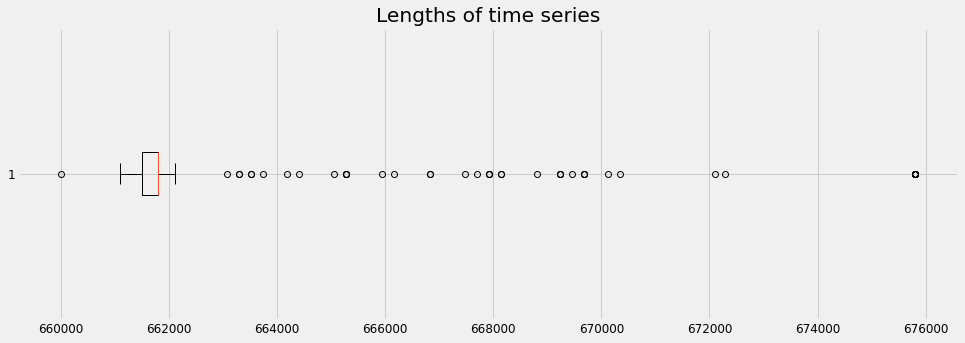

In [3]:
time_series_data_lens = [len(x) for x in time_series_data]

plt.subplots(figsize=(15, 5))
plt.boxplot(time_series_data_lens, vert=False)
plt.title('Lengths of time series')
plt.show()


In [4]:
print('max',max(time_series_data_lens))
print('min',min(time_series_data_lens))
print('difference',max(time_series_data_lens) - min(time_series_data_lens))


max 675808
min 660000
difference 15808


In [5]:
maxsize = max(time_series_data_lens)

X = np.zeros(shape=(1000, maxsize))
for i in range(1000):
    X[i][0:time_series_data_lens[i]] = time_series_data[i]
    
y = np.array(labels).reshape(1000, 1)


Creating splits

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20)


Normalizing the data

In [12]:
X_train = StandardScaler().fit_transform(X_train)

X_test = StandardScaler().fit_transform(X_test),



In [7]:
# %python3 -m install tensorflow-macos

In [22]:
import tensorflow as tf
from tensorflow import keras as k
from keras.models import Sequential
from keras.layers import  Conv1D

In [14]:
X_train.shape

(800, 675808)

In [16]:
def trainModel(model, epochs, optimizer, X_train, y_train, X_test, y_test):
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy')
    return model.fit(X_train, y_train, validation_data=(X_test, y_test),
                     epochs=epochs)


In [17]:
def plotValidate(history):
    print("Validation Accuracy: " + max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12, 6))
    plt.show


In [ ]:
cnn_time_series = k.models.Sequential([
    k.layers.Dense(512, activation='relu',
                   input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])

print(cnn_time_series.summary())

cnn_history_audio = trainModel(model=cnn_time_series, epochs=600, optimizer='adam',
                               X_train=X_train, y_train=y_train,
                               X_test=X_test, y_test=y_test)


In [28]:
model = Sequential()
model.add(Conv1D(filters = 512, kernel_size = 3, activation='relu', input_shape=X.shape))


In [29]:
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(k.layers.Dropout(0.5))
model.add(k.layers.MaxPooling1D(pool_size=2))
model.add(k.layers.Flatten())
model.add(k.layers.Dense(100, activation='relu'))
model.add(k.layers.Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])


In [37]:

verbose, epochs, batch_size = 0, 10, 32
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
# fit network
model.fit(X_train, y_train, epochs=epochs,
            batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print(accuracy)

ValueError: in user code:

    File "/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 1000, 675808), found shape=(32, 675808)
